# Data Preparation

## Data Collection

In [14]:
import pandas as pd
from datasets import load_dataset, load_from_disk
import matplotlib.pyplot as plt
import random
from PIL import Image
import io
import re

In [2]:
# # load the dataset from huggingface
# dataset = load_dataset("mtg_image_data", split="train")

# # save the dataset to disk
# dataset.save_to_disk("data/mtg-image-data")

# load the dataset from disk
dataset = load_from_disk("data/mtg-image-data")
dataset

Dataset({
    features: ['image', 'Unnamed: 0', 'text'],
    num_rows: 27000
})

In [4]:
df = dataset.to_pandas()
df.head()

,image,Unnamed: 0,text
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,17785,"MTG card art, +2 Mace, by Jarel Threat, 2021, ..."
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,4372,"MTG card art, A-Ardent Dustspeaker, by Mads Ah..."
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,25418,"MTG card art, A-Baba Lysaga, Night Witch, by S..."
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,6378,"MTG card art, A-Binding Geist, by Campbell Whi..."
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,21834,"MTG card art, A-Brine Comber, by Olena Richard..."


In [31]:
df.dtypes

image         object
Unnamed: 0     int64
mana_color    object
dtype: object

In [25]:
# Extract the features (U, B, W, G, R, C) from the text, searching for pattern like ', U,' and the new feature with name "mana_color"

def extract_features(text):
    features = re.findall(r", (U|B|W|G|R|C),", text)
    feature = pd.NA if len(features) == 0 else features[0]
    return feature

# Add the extracted features to the dataframe
df['mana_color'] = df['text'].apply(extract_features)
df.head()

,image,Unnamed: 0,text,mana_color
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,17785,"MTG card art, +2 Mace, by Jarel Threat, 2021, ...",W
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,4372,"MTG card art, A-Ardent Dustspeaker, by Mads Ah...",R
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,25418,"MTG card art, A-Baba Lysaga, Night Witch, by S...",<NA>
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,6378,"MTG card art, A-Binding Geist, by Campbell Whi...",U
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,21834,"MTG card art, A-Brine Comber, by Olena Richard...",<NA>


In [26]:
df.isna().sum()

image            0
Unnamed: 0       0
text             0
mana_color    3152
dtype: int64

In [29]:
df.dropna(inplace=True)
df.drop(columns=['text'], inplace=True)
df.isna().sum()

image         0
Unnamed: 0    0
mana_color    0
dtype: int64

In [35]:
df.rename(columns={'Unnamed: 0':'id'}, inplace=True)
df.id.duplicated().sum()

0

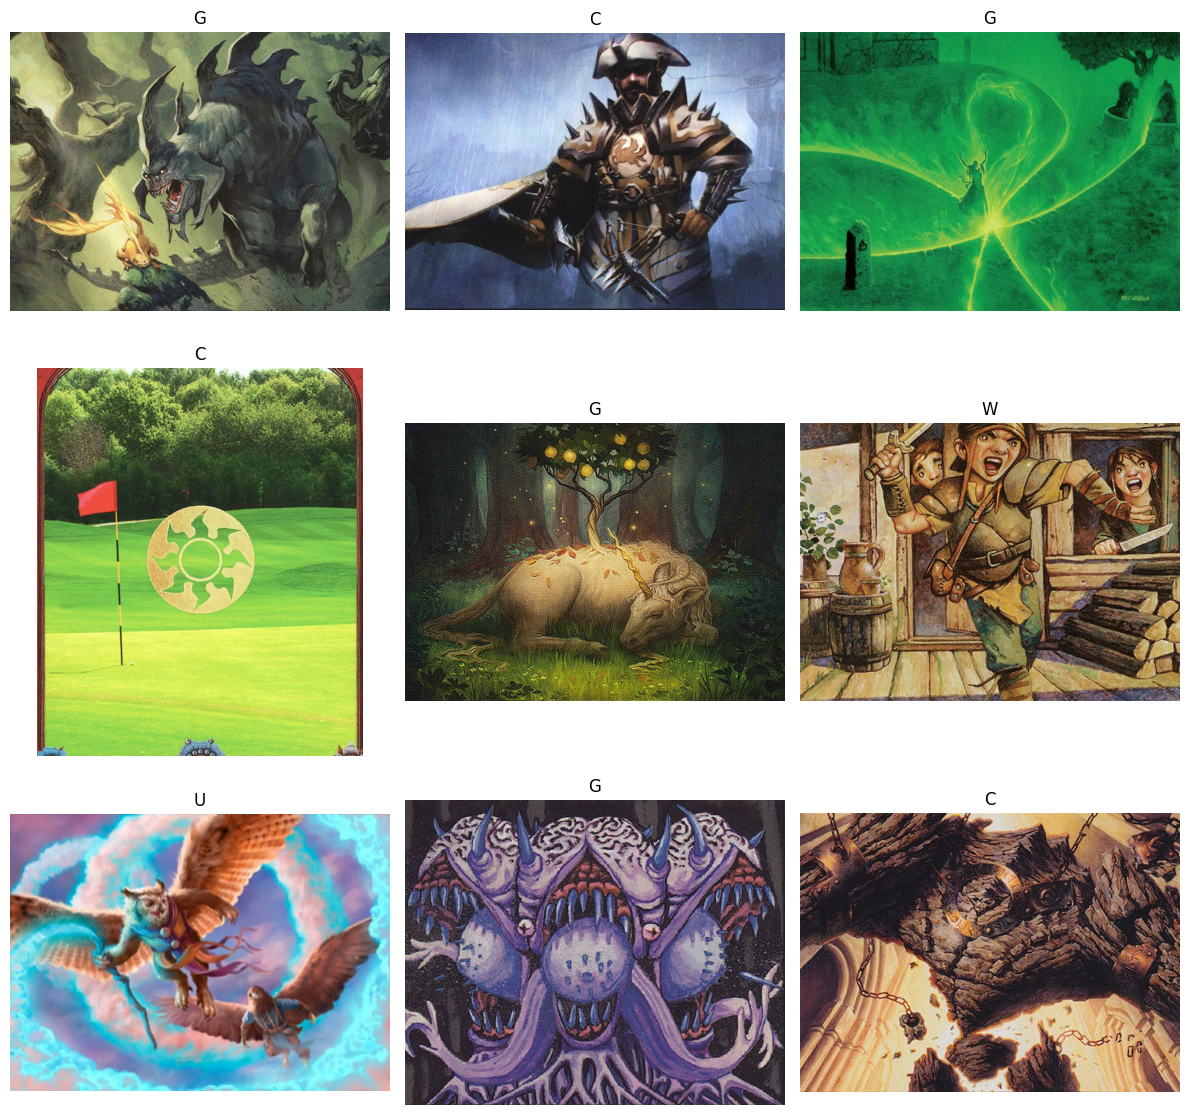

In [36]:
# Define a function to visualize images (in {'bytes': b....} format)
def visualize_images(df, num_images=9, rows=3, cols=3):
    fig, axes = plt.subplots(rows, cols, figsize=(12, 12))

    for i in range(num_images):
        idx = random.randint(0, len(df))
        img = Image.open(io.BytesIO(df.iloc[idx]["image"]["bytes"]))
        ax = axes[i // cols, i % cols]
        ax.imshow(img)
        ax.axis("off")
        ax.title.set_text(df.iloc[idx]["mana_color"])
    plt.tight_layout()
    plt.show()

# Visualize some random images from the dataset
visualize_images(df)
